In [1]:
import os
import torch
import numpy as np
import imageio
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from time import time as time

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torchnet as tnt
import functools

from distutils.dir_util import copy_tree
import mock
from tqdm import notebook as tqdm


# GLOBAL SETTINGS
PlotSize = 12                                     # Size of plots
matplotlib.rcParams['figure.figsize'] = [PlotSize*2, PlotSize]  
CMAP = matplotlib.colors.ListedColormap(['black', 'white', 'orange'])               # Color mapping 
np.set_printoptions(precision=2, suppress=True)  # Array print precision

# CLASS AND FEATURE DESCRIPTION
class_names = ['BACKGRD','PINUS','PICEA']

# PATHS TO TRAIN/TEST DATA
data_path = '../data/jeseniky/blackandwhite/'
training_set_path = data_path + 'train/'         # Relative path to training patch root folder
test_set_path =     data_path + 'test/'          # Relative path to test patch root folder

num_of_training_tiles = len(os.listdir(training_set_path + 'GT/'))
num_of_test_tiles = len(os.listdir(test_set_path + 'GT/'))
print(num_of_test_tiles)
print(num_of_training_tiles)

# USE CIR OR RGB DATA
use_cir = False
use_rgb = False
use_pan = True

# MODEL NAME... USED AS FILENAME OF SAVED MODEL AND FOR APPROPRIATE RESULTS FOLDER
model_name = 'KrakonosNet'

511
1117


In [15]:
def read_patch(root_folder, cir, rgb, pan, gt=True):
    ##########################################################
    # READ IMAGES as FLOAT
    
    if cir:
        cir_file_list = os.listdir(root_folder + 'CIR/')
        cir_list = []
        
        for file in cir_file_list:
            cir_patch = imageio.imread(root_folder + 'CIR/' + file).astype(np.float32)
            cir_patch = cir_patch[:,:,:].transpose([2,0,1])
            cir_patch = cir_patch * 1/255
            
            cir_list.append(cir_patch)
            del cir_patch

        cir_features = np.stack(cir_list, axis=0)    
    
    if rgb:
        rgb_file_list = os.listdir(root_folder + 'RGB/')
        rgb_list = []
        
        for file in rgb_file_list:
            rgb_patch = imageio.imread(root_folder + 'RGB/' + file).astype(np.float32)
            rgb_patch = rgb_patch[:,:,:].transpose([2,0,1])
            rgb_patch = rgb_patch * 1/255
            
            rgb_list.append(rgb_patch)
            
            del rgb_patch
        
        rgb_features = np.stack(rgb_list, axis=0)

    if pan:
        pan_file_list = os.listdir(root_folder + 'PAN/')
        pan_list = []
        
        for file in pan_file_list:
            pan_patch = imageio.imread(root_folder + 'PAN/' + file).astype(np.float32)
            pan_patch = pan_patch * 1/255
            pan_patch = np.expand_dims(pan_patch, axis=0)
            
            pan_list.append(pan_patch)
            
            del pan_patch
        
        pan_features = np.stack(pan_list, axis=0)


    if cir and rgb:
        features = np.concatenate([cir_features, rgb_features], axis=1)
    elif cir:
        features = cir_features
    elif rgb:
        features = rgb_features
    elif pan:
        features = pan_features
    else:
        print('No valid data input.')
    features = torch.from_numpy(features)
    
    
    if gt:
        gt_file_list = os.listdir(root_folder + 'GT/')
        gt_list = []

        for file in gt_file_list:
            gt_patch = imageio.imread(root_folder + 'GT/' + file).astype(np.int64)
 
            gt_list.append(gt_patch[:,:])
            del gt_patch

        ground_truth = np.stack(gt_list, axis=0)
        ground_truth = torch.from_numpy(ground_truth)
    
    if gt:
        return features, ground_truth
    else:
        return features

In [16]:
### putting the dataset into the TensorDataset wrapper
X, y = read_patch(training_set_path, use_cir, use_rgb, use_pan)
X_t, y_t = read_patch(test_set_path, use_cir, use_rgb, use_pan)

print(X.shape)
print(y.shape)
print(X_t.shape)


train_set = tnt.dataset.TensorDataset(list([X, y]))
test_set  = tnt.dataset.TensorDataset(list([X_t, y_t]))
print(len(train_set))

torch.Size([1117, 1, 512, 512])
torch.Size([1117, 512, 512])
torch.Size([511, 1, 512, 512])
1117


In [4]:
class KrakonosNet(nn.Module):
    """
    KrakonosNet network based on U-Net for semantic segmentation
    """
  
    def __init__(self, n_channels, encoder_conv_width, decoder_conv_width, n_class, cuda):
        """
        initialization function
        n_channels, int, number of input channel
        encoder_conv_width, int list, size of the feature maps of convs for the encoder
        decoder_conv_width, int list, size of the feature maps of convs for the decoder
        n_class = int,  the number of classes
        """
        super(KrakonosNet, self).__init__() #necessary for all classes extending the module class
    
        self.maxpool=nn.MaxPool2d(2,2,return_indices=False) #maxpooling layer
        self.dropout=nn.Dropout2d(p=0.5, inplace=True)
    
        #encoder
        self.c1 = nn.Sequential(nn.Conv2d(n_channels,encoder_conv_width[0],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[0]),nn.PReLU())
        self.c2 = nn.Sequential(nn.Conv2d(encoder_conv_width[0],encoder_conv_width[1],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[1]),nn.PReLU())
        self.c3 = nn.Sequential(nn.Conv2d(encoder_conv_width[1],encoder_conv_width[2],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[2]),nn.PReLU())
        self.c4 = nn.Sequential(nn.Conv2d(encoder_conv_width[2],encoder_conv_width[3],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[3]),nn.PReLU())
        self.c5 = nn.Sequential(nn.Conv2d(encoder_conv_width[3],encoder_conv_width[4],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[4]),nn.PReLU())
        self.c6 = nn.Sequential(nn.Conv2d(encoder_conv_width[4],encoder_conv_width[5],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[5]),nn.PReLU())
        self.c7 = nn.Sequential(nn.Conv2d(encoder_conv_width[5],encoder_conv_width[6],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[6]),nn.PReLU())
        self.c8 = nn.Sequential(nn.Conv2d(encoder_conv_width[6],encoder_conv_width[7],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[7]),nn.PReLU())
        self.c9 = nn.Sequential(nn.Conv2d(encoder_conv_width[7],encoder_conv_width[8],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[8]),nn.PReLU())
        self.c10 = nn.Sequential(nn.Conv2d(encoder_conv_width[8],encoder_conv_width[9],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[9]),nn.PReLU())
        #decoder
        self.c11 = nn.ConvTranspose2d(encoder_conv_width[9], int(decoder_conv_width[0]/2),kernel_size=2, stride=2)
        self.c12 = nn.Sequential(nn.Conv2d(decoder_conv_width[0],decoder_conv_width[1],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[1]),nn.PReLU())
        self.c13 = nn.Sequential(nn.Conv2d(decoder_conv_width[1],decoder_conv_width[2],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[2]),nn.PReLU())
        self.c14 = nn.ConvTranspose2d(decoder_conv_width[2], int(decoder_conv_width[3]/2),kernel_size=2, stride=2)
        self.c15 = nn.Sequential(nn.Conv2d(decoder_conv_width[3],decoder_conv_width[4],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[4]),nn.PReLU())
        self.c16 = nn.Sequential(nn.Conv2d(decoder_conv_width[4],decoder_conv_width[5],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[5]),nn.PReLU())
        self.c17 = nn.ConvTranspose2d(decoder_conv_width[5], int(decoder_conv_width[6]/2),kernel_size=2, stride=2)
        self.c18 = nn.Sequential(nn.Conv2d(decoder_conv_width[6],decoder_conv_width[7],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[7]),nn.PReLU())
        self.c19 = nn.Sequential(nn.Conv2d(decoder_conv_width[7],decoder_conv_width[8],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[8]),nn.PReLU())
        self.c20 = nn.ConvTranspose2d(decoder_conv_width[8], int(decoder_conv_width[9]/2),kernel_size=2, stride=2)
        self.c21 = nn.Sequential(nn.Conv2d(decoder_conv_width[9],decoder_conv_width[10],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[10]),nn.PReLU())
        self.c22 = nn.Sequential(nn.Conv2d(decoder_conv_width[10],decoder_conv_width[11],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[11]),nn.PReLU()) 
        
        #final classifying layer
        self.classifier=nn.Conv2d(decoder_conv_width[11],n_class,1,padding=0)

        #weight initialization

        self.c1[0].apply(self.init_weights)
        self.c2[0].apply(self.init_weights)
        self.c3[0].apply(self.init_weights)
        self.c4[0].apply(self.init_weights)
        self.c5[0].apply(self.init_weights)
        self.c6[0].apply(self.init_weights)
        self.c7[0].apply(self.init_weights)
        self.c8[0].apply(self.init_weights)
        self.c9[0].apply(self.init_weights)
        self.c10[0].apply(self.init_weights)
        
        self.c12[0].apply(self.init_weights)
        self.c13[0].apply(self.init_weights)
        
        self.c15[0].apply(self.init_weights)
        self.c16[0].apply(self.init_weights)
        
        self.c18[0].apply(self.init_weights)
        self.c19[0].apply(self.init_weights)
        
        self.c21[0].apply(self.init_weights)
        self.c22[0].apply(self.init_weights)
        self.classifier.apply(self.init_weights)
    
        if cuda: #put the model on the GPU memory
            self.cuda()
    
    def init_weights(self,layer): #gaussian init for the conv layers
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
    
    def forward(self,input):
        """
        the function called to run inference
        """  
        #encoder
        #level 1
        x1 = self.c2(self.c1(input))
        x2 = self.maxpool(x1)
        #level 2
        x3 = self.c4(self.c3(x2))
        x4 = self.maxpool(x3)
        #level 3
        x5 = self.c6(self.c5(x4))
        x6 = self.maxpool(x5)
        #Level 4
        x7 = self.c8(self.c7(x6))
        x8 = self.maxpool(x7)
        #Level 5
        x9 = self.c10(self.c9(x8))
        #decoder
        #Level 4
        y8 = torch.cat((self.c11(x9),x7),1)
        y7 = self.c13(self.c12(y8))
        #Level 3
        y6 = torch.cat((self.c14(y7),x5),1)
        y5 = self.c16(self.c15(y6))
        #level 2
        y4 = torch.cat((self.c17(y5),x3),1)
        y3 = self.c19(self.c18(y4))
        #level 1       
        y2 = torch.cat((self.c20(y3),x1),1)
        y1 = self.c22(self.c21(y2))
        #output         
        out = self.classifier(self.dropout(y1))
    
        return out

In [18]:
def augment(obs, g_t):
    """the augmentation function
    do not change until you reach Q14
    """
    sigma, clip= 0.01, 0.03 
    #Hint: use np.clip to clip and np.random.randn to generate gaussian noise
    obs = obs + np.clip(sigma*np.random.randn(), -clip, clip).astype(np.float32).copy()

    #random rotation 0 90 180 270 degree
    n_turn = np.random.randint(4) #number of 90 degree truens, random int between 0 and 3
    obs = np.rot90(obs, n_turn, axes=(2,3)).copy()
    g_t = np.rot90(g_t, n_turn, axes=(1,2)).copy()

    obs = torch.from_numpy(obs)
    g_t = torch.from_numpy(g_t)
    
    return obs, g_t

In [6]:
def train(model, optimizer, args):
    """train for one epoch"""
    model.train() #switch the model in training mode
  
    #the loader function will take care of the batching
    loader = torch.utils.data.DataLoader(train_set, \
         batch_size=args.batch_size, shuffle=True, drop_last=True)
    loader = tqdm.tqdm(loader, ncols=500)
  
    #will keep track of the loss
    loss_meter = tnt.meter.AverageValueMeter()

    for index, (tiles, gt) in enumerate(loader):
    
        optimizer.zero_grad() #put gradient to zero
                
        tiles, gt = augment(tiles, gt)
    
        pred = model(tiles.cuda()) #compute the prediction

        loss = nn.functional.cross_entropy(pred.cpu(),gt, weight=torch.tensor(args.class_weights))

        loss.backward() #compute gradients

        for p in model.parameters(): #we clip the gradient at norm 1
            p.grad.data.clamp_(-1, 1) #this helps learning faster
    
        optimizer.step() #one SGD step
    
        loss_meter.add(loss.item())
        
    return loss_meter.value()[0]

def eval(model, args):
    """eval on test/validation set"""
  
    model.eval() #switch in eval mode
  
    loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, drop_last=False)
    loader = tqdm.tqdm(loader, ncols=500)
  
    loss_meter = tnt.meter.AverageValueMeter()

    with torch.no_grad():
        for index, (tiles, gt) in enumerate(loader):
            pred = model(tiles.cuda())
            loss = nn.functional.cross_entropy(pred.cpu(),gt)
            loss_meter.add(loss.item())

    return loss_meter.value()[0]


def train_full(args):
    """The full training loop"""

    #initialize the model
    model = KrakonosNet(args.n_channel, args.conv_width, args.dconv_width, args.n_class, args.cuda)

    print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))
  
    #define the optimizer
    #adam optimizer is always a good guess for classification
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[65,80,90], gamma=0.3)
  
    TESTCOLOR = '\033[104m'
    NORMALCOLOR = '\033[0m'
  
    train_loss = np.empty(args.n_epoch)
    test_loss = np.empty(args.n_epoch//args.n_epoch_test)
    test_i = 0

    for i_epoch in range(args.n_epoch):
        #train one epoch
        print('Epoch ' + str(i_epoch))
        loss_train = train(model, optimizer, args)
        scheduler.step()
        train_loss[i_epoch] = loss_train

        if (i_epoch == args.n_epoch - 1) or (args.n_epoch_test != 0 and i_epoch % args.n_epoch_test == 0 and i_epoch > 0):
            #periodic testing
            print(TESTCOLOR)
            print('Evaluation')
            loss_test = eval(model, args)
            test_loss[test_i] = loss_test
            test_i += 1

    plt.figure(figsize=(10, 10))
    plt.subplot(1,1,1,ylim=(0,2), xlabel='Epoch #', ylabel='Loss')
    plt.plot(range(args.n_epoch), train_loss)
    plt.plot(range(args.n_epoch_test-1, args.n_epoch, args.n_epoch_test), test_loss)
    plt.show()
    print(train_loss)
    print(test_loss)
    
    return model

In [7]:
args = mock.Mock() #stores the parameters
args.n_epoch = 100
args.n_epoch_test = int(5) #periodicity of evaluation on test set
args.batch_size = 2
args.n_class = len(class_names)
args.n_channel = 1 # 6 if use_cir and use_rgb else 3
args.conv_width = [32,32,64,64,128,128,256,256,512,512]
args.dconv_width = [512,256,256,256,128,128,128,64,64,64,32,32]
args.class_weights = [0.2, 0.2, 0.6]
args.cuda = True
args.lr = 5e-5

In [ ]:
a = time()
trained_model = train_full(args)
b = time()

print('Training finished in ' + str(b-a) + 's')

Learning rate for this run is 1e-07
Total number of parameters: 7765493
Epoch 0



Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5




Evaluation



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10




Evaluation



Epoch 11



Epoch 12



Epoch 13



Epoch 14



Epoch 15




Evaluation



Epoch 16



Epoch 17



Epoch 18



Epoch 19



Epoch 20




Evaluation



Epoch 21



Epoch 22



Epoch 23



Epoch 24



Epoch 25




Evaluation



Epoch 26



Epoch 27



Epoch 28



Epoch 29



Epoch 30




Evaluation



Epoch 31



Epoch 32



Epoch 33



Epoch 34



Epoch 35




Evaluation



Epoch 36



Epoch 37



Epoch 38



Epoch 39



Epoch 40




Evaluation



Epoch 41



Epoch 42



Epoch 43



Epoch 44



Epoch 45




Evaluation



Epoch 46



Epoch 47



Epoch 48



Epoch 49



Epoch 50




Evaluation



Epoch 51



Epoch 52



Epoch 53



Epoch 54



Epoch 55




Evaluation



Epoch 56



Epoch 57



Epoch 58



Epoch 59



Epoch 60




Evaluation



Epoch 61



Epoch 62



Epoch 63



Epoch 64



Epoch 65




Evaluation



Epoch 66



Epoch 67



Epoch 68



Epoch 69



Epoch 70




Evaluation



Epoch 71



Epoch 72



Epoch 73



Epoch 74



Epoch 75




Evaluation



Epoch 76



Epoch 77



Epoch 78



Epoch 79



Epoch 80




Evaluation



Epoch 81



Epoch 82



Epoch 83



Epoch 84



Epoch 85




Evaluation



Epoch 86



Epoch 87



Epoch 88



Epoch 89



Epoch 90




Evaluation



Epoch 91



Epoch 92



Epoch 93



Epoch 94



Epoch 95




Evaluation



Epoch 96



Epoch 97



Epoch 98



Epoch 99




Evaluation


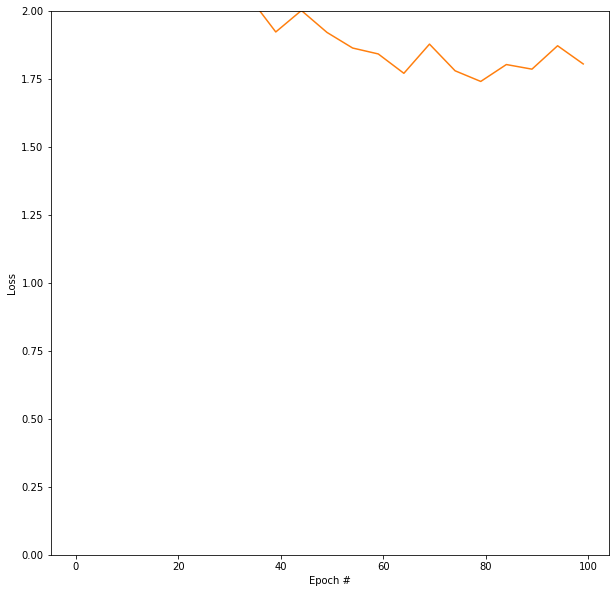

[3.58 3.55 3.51 3.51 3.47 3.47 3.46 3.42 3.37 3.4  3.33 3.35 3.32 3.3
 3.3  3.27 3.28 3.25 3.25 3.21 3.22 3.19 3.18 3.16 3.18 3.17 3.18 3.15
 3.14 3.13 3.12 3.11 3.11 3.09 3.06 3.09 3.06 3.05 3.04 3.03 3.03 3.02
 3.02 3.   3.02 2.99 3.   2.96 2.96 2.94 2.91 2.93 2.9  2.89 2.92 2.85
 2.89 2.86 2.86 2.84 2.85 2.84 2.81 2.84 2.8  2.79 2.82 2.82 2.83 2.81
 2.81 2.82 2.78 2.78 2.77 2.76 2.78 2.74 2.78 2.75 2.73 2.79 2.77 2.77
 2.74 2.74 2.79 2.77 2.75 2.74 2.74 2.77 2.76 2.76 2.77 2.74 2.75 2.77
 2.76 2.74]
[2.57 2.46 2.23 2.19 2.13 2.13 2.05 1.92 2.   1.92 1.86 1.84 1.77 1.88
 1.78 1.74 1.8  1.79 1.87 1.81]
Training finished in 16331.526891946793s
Learning rate for this run is 1e-06
Total number of parameters: 7765493
Epoch 0



Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5




Evaluation



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10




Evaluation



Epoch 11



Epoch 12



Epoch 13



Epoch 14



Epoch 15




Evaluation



Epoch 16



Epoch 17



Epoch 18



Epoch 19



Epoch 20




Evaluation



Epoch 21



Epoch 22



Epoch 23



Epoch 24



Epoch 25




Evaluation



Epoch 26



Epoch 27



Epoch 28



Epoch 29



Epoch 30




Evaluation



Epoch 31



Epoch 32



Epoch 33



Epoch 34



Epoch 35




Evaluation



Epoch 36



Epoch 37



Epoch 38



Epoch 39



Epoch 40




Evaluation



Epoch 41



Epoch 42



Epoch 43



Epoch 44



Epoch 45




Evaluation



Epoch 46



Epoch 47



Epoch 48



Epoch 49



Epoch 50




Evaluation



Epoch 51



Epoch 52



Epoch 53



Epoch 54



Epoch 55




Evaluation



Epoch 56



Epoch 57



Epoch 58



Epoch 59



Epoch 60




Evaluation



Epoch 61



Epoch 62



Epoch 63



Epoch 64



Epoch 65




Evaluation



Epoch 66



Epoch 67



Epoch 68



Epoch 69



Epoch 70




Evaluation



Epoch 71



Epoch 72



Epoch 73



Epoch 74



Epoch 75




Evaluation



Epoch 76



Epoch 77



Epoch 78



Epoch 79



Epoch 80




Evaluation



Epoch 81



Epoch 82



Epoch 83



Epoch 84



Epoch 85




Evaluation



Epoch 86



Epoch 87



Epoch 88



Epoch 89



Epoch 90




Evaluation



Epoch 91



Epoch 92



Epoch 93



Epoch 94



Epoch 95




Evaluation



Epoch 96



Epoch 97



Epoch 98



Epoch 99




Evaluation


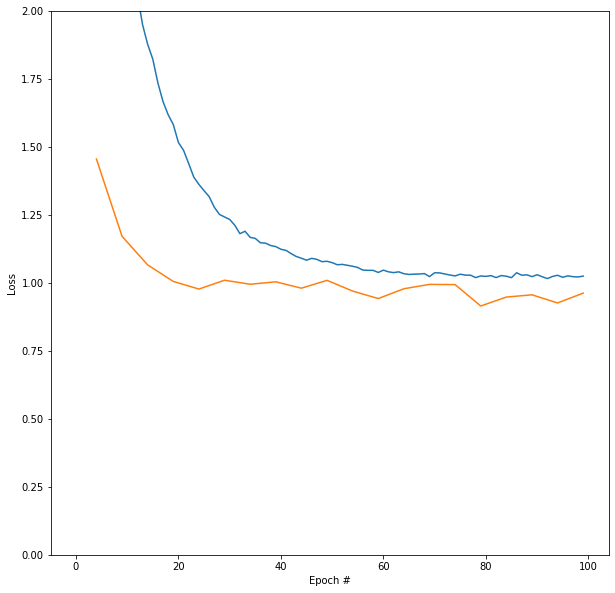

[3.85 3.55 3.43 3.24 3.06 2.93 2.78 2.63 2.51 2.37 2.26 2.15 2.06 1.95
 1.88 1.82 1.74 1.67 1.62 1.58 1.52 1.49 1.44 1.39 1.36 1.34 1.32 1.28
 1.25 1.24 1.23 1.21 1.18 1.19 1.17 1.16 1.15 1.15 1.14 1.13 1.12 1.12
 1.11 1.1  1.09 1.08 1.09 1.09 1.08 1.08 1.07 1.07 1.07 1.07 1.06 1.06
 1.05 1.05 1.05 1.04 1.05 1.04 1.04 1.04 1.03 1.03 1.03 1.03 1.03 1.02
 1.04 1.04 1.03 1.03 1.03 1.03 1.03 1.03 1.02 1.03 1.02 1.03 1.02 1.03
 1.03 1.02 1.04 1.03 1.03 1.02 1.03 1.02 1.02 1.02 1.03 1.02 1.03 1.02
 1.02 1.03]
[1.46 1.17 1.07 1.01 0.98 1.01 1.   1.   0.98 1.01 0.97 0.94 0.98 0.99
 0.99 0.92 0.95 0.96 0.93 0.96]
Training finished in 16443.477019309998s
Learning rate for this run is 1e-05
Total number of parameters: 7765493
Epoch 0



Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5




Evaluation



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10




Evaluation



Epoch 11



Epoch 12



Epoch 13



Epoch 14



Epoch 15




Evaluation



Epoch 16



Epoch 17



Epoch 18



Epoch 19



Epoch 20




Evaluation



Epoch 21



Epoch 22



Epoch 23



Epoch 24



Epoch 25




Evaluation



Epoch 26



Epoch 27



Epoch 28



Epoch 29



Epoch 30




Evaluation



Epoch 31



Epoch 32



Epoch 33



Epoch 34



Epoch 35




Evaluation



Epoch 36



Epoch 37



Epoch 38



Epoch 39



Epoch 40




Evaluation



Epoch 41



Epoch 42



Epoch 43



Epoch 44



Epoch 45




Evaluation



Epoch 46



Epoch 47



Epoch 48



Epoch 49



Epoch 50




Evaluation



Epoch 51



Epoch 52



Epoch 53



Epoch 54



Epoch 55




Evaluation



Epoch 56



Epoch 57



Epoch 58



Epoch 59



Epoch 60




Evaluation



Epoch 61



Epoch 62



Epoch 63



Epoch 64



Epoch 65




Evaluation



Epoch 66



Epoch 67



Epoch 68



Epoch 69



Epoch 70




Evaluation



Epoch 71



Epoch 72



Epoch 73



Epoch 74



Epoch 75




Evaluation



Epoch 76



Epoch 77



Epoch 78



Epoch 79



Epoch 80




Evaluation



Epoch 81



Epoch 82



Epoch 83



Epoch 84



Epoch 85




Evaluation



Epoch 86



Epoch 87



Epoch 88



Epoch 89



Epoch 90




Evaluation



Epoch 91



Epoch 92



Epoch 93



Epoch 94



Epoch 95




Evaluation



Epoch 96



Epoch 97



Epoch 98



Epoch 99




Evaluation


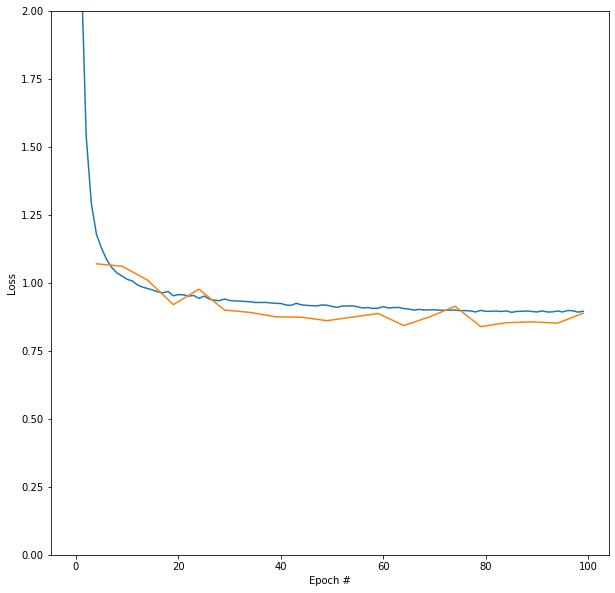

[3.29 2.18 1.54 1.29 1.18 1.13 1.09 1.06 1.04 1.03 1.01 1.01 0.99 0.99
 0.98 0.97 0.97 0.96 0.97 0.95 0.96 0.96 0.95 0.95 0.94 0.95 0.94 0.94
 0.94 0.94 0.94 0.93 0.93 0.93 0.93 0.93 0.93 0.93 0.93 0.93 0.92 0.92
 0.92 0.93 0.92 0.92 0.92 0.92 0.92 0.92 0.91 0.91 0.92 0.92 0.92 0.91
 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.91 0.9  0.9  0.9  0.9  0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.89 0.9  0.9  0.9  0.9  0.9
 0.9  0.89 0.9  0.9  0.9  0.9  0.89 0.9  0.89 0.89 0.9  0.89 0.9  0.9
 0.89 0.9 ]
[1.07 1.06 1.01 0.92 0.98 0.9  0.89 0.88 0.87 0.86 0.87 0.89 0.84 0.88
 0.91 0.84 0.85 0.86 0.85 0.89]
Training finished in 16717.56659936905s
Learning rate for this run is 0.0001
Total number of parameters: 7765493
Epoch 0



Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5




Evaluation



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10




Evaluation



Epoch 11



Epoch 12



Epoch 13



Epoch 14



Epoch 15




Evaluation



Epoch 16



Epoch 17



Epoch 18



Epoch 19



Epoch 20




Evaluation



Epoch 21



Epoch 22



Epoch 23



Epoch 24



Epoch 25




Evaluation



Epoch 26



Epoch 27



Epoch 28



Epoch 29



Epoch 30




Evaluation



Epoch 31



Epoch 32



Epoch 33



Epoch 34



Epoch 35




Evaluation



Epoch 36



Epoch 37



Epoch 38



Epoch 39



Epoch 40




Evaluation



Epoch 41



Epoch 42



Epoch 43



Epoch 44



Epoch 45




Evaluation



Epoch 46



Epoch 47



Epoch 48



Epoch 49



Epoch 50




Evaluation



Epoch 51



Epoch 52



Epoch 53



Epoch 54



Epoch 55




Evaluation



Epoch 56



Epoch 57



Epoch 58



Epoch 59



Epoch 60




Evaluation



Epoch 61



Epoch 62



Epoch 63



Epoch 64



Epoch 65




Evaluation



Epoch 66



Epoch 67



Epoch 68



Epoch 69



Epoch 70




Evaluation



Epoch 71



Epoch 72



Epoch 73



Epoch 74



Epoch 75




Evaluation



Epoch 76



Epoch 77



Epoch 78



Epoch 79



Epoch 80




Evaluation



Epoch 81



Epoch 82



Epoch 83



Epoch 84



Epoch 85




Evaluation



Epoch 86



Epoch 87



Epoch 88



Epoch 89



Epoch 90




Evaluation



Epoch 91



Epoch 92



Epoch 93



Epoch 94



Epoch 95




Evaluation



Epoch 96



Epoch 97



Epoch 98



Epoch 99




Evaluation


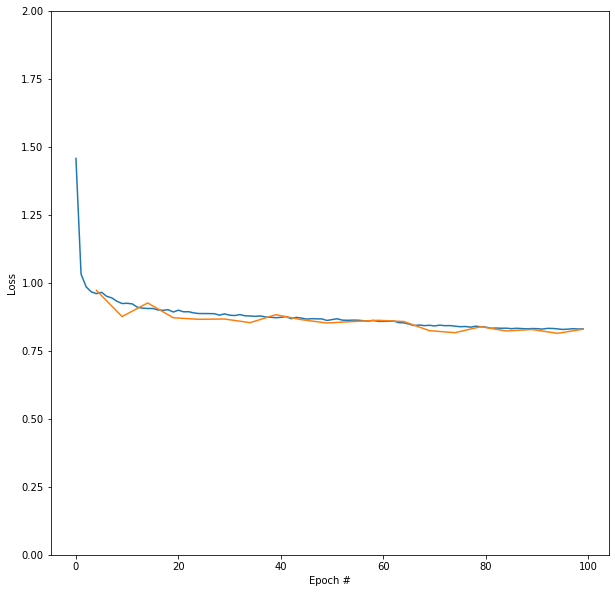

[1.46 1.03 0.99 0.97 0.96 0.97 0.95 0.95 0.93 0.92 0.93 0.92 0.91 0.91
 0.91 0.91 0.9  0.9  0.9  0.89 0.9  0.89 0.89 0.89 0.89 0.89 0.89 0.89
 0.88 0.89 0.88 0.88 0.88 0.88 0.88 0.88 0.88 0.87 0.87 0.87 0.87 0.88
 0.87 0.87 0.87 0.87 0.87 0.87 0.87 0.86 0.87 0.87 0.86 0.86 0.86 0.86
 0.86 0.86 0.86 0.86 0.86 0.86 0.86 0.85 0.85 0.85 0.84 0.85 0.84 0.84
 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.83 0.83 0.83
 0.83 0.83 0.83 0.83 0.83 0.83 0.83 0.83 0.83 0.83 0.83 0.83 0.83 0.83
 0.83 0.83]
[0.97 0.88 0.93 0.87 0.87 0.87 0.85 0.88 0.87 0.85 0.86 0.86 0.86 0.82
 0.82 0.84 0.82 0.83 0.81 0.83]
Training finished in 16641.346187353134s
Learning rate for this run is 0.001
Total number of parameters: 7765493
Epoch 0



Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5




Evaluation



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10




Evaluation



Epoch 11



Epoch 12



Epoch 13



Epoch 14



Epoch 15




Evaluation



Epoch 16



Epoch 17



Epoch 18



Epoch 19


In [ ]:
# training multiple models
learning_rates = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
trained_models = []
for i in learning_rates:
    args.lr = i
    print('Learning rate for this run is ' + str(i))
    a = time()
    trained_models.append(train_full(args))
    b = time()
    print('Training finished in ' + str(b-a) + 's')

## Result visualisation

In [ ]:
def plot_rgb_cir_gt_pred(tile_index, data, gt, model, cir, rgb):
    # Function to plot prediction vs ground truth
    
    # Plotting
    plt.figure(facecolor='white')

    data = data[tile_index,:,:,:]
    pred = model(data[None,:,:,:].cuda()).cpu().detach().numpy()
    pred = pred[0,:,:,:].argmax(0).squeeze()
    
    unique, counts = np.unique(pred, return_counts=True)
    print(dict(zip(unique, counts)))
    
    data = data.cpu().numpy()
    
    if cir and rgb:
        plt.subplot(1, 4, 1)
        plt.imshow(data[:3].transpose([1,2,0]))
        plt.title('NIR Red Green composite')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(data[-3:].transpose([1,2,0]))
        plt.title('Red Green Blue composite')
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.imshow(gt[tile_index,:,:], CMAP)
        plt.title('GT Labels')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(pred, CMAP)
        plt.title('Predicted Labels')
        plt.axis('off')
    
    elif cir or rgb:
        plt.subplot(1, 3, 1)
        plt.imshow(data.transpose([1,2,0]))
        if cir:
            plt.title('NIR Red Green composite')
        else:
            plt.title('Red Green Blue composite')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt[tile_index,:,:], CMAP)
        plt.title('GT Labels')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred, CMAP)
        plt.title('Predicted Labels')
        plt.axis('off')

In [ ]:
plot_rgb_cir_gt_pred(50, X_t, y_t, trained_models[0], use_cir, use_rgb)

## Computing accuracy metrics

In [ ]:
def classify(model, args):
    """eval on test/validation set"""
  
    model.eval() #switch in eval mode
    loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, drop_last=False)
    loader = tqdm.tqdm(loader, ncols=500)
    
    classified = np.empty_like(y_t.detach().numpy())
    
    with torch.no_grad():
        for index, (tiles, gt) in enumerate(loader):
            pred = model(tiles.cuda()).cpu().detach().numpy()
            classified[index, :, :] = pred.squeeze().argmax(0)

    return classified

In [ ]:
a = time()
Y_t = classify(trained_models[2], args)
b = time()
print('Inferrence finished in ' + str(b-a) + ' s')

Y_t_flat = Y_t.flatten()

unique, counts = np.unique(Y_t_flat, return_counts=True)
print(unique)
print(counts)

In [ ]:
# write the results for all test tiles into one file, used later for visualisation
imageio.imwrite(data_path + 'results/KrakonosNet.tif', Y_t_flat.reshape(2,int(Y_t_flat.shape[0]/2)).astype(np.uint8), bigtiff=True)

In [ ]:
y_t_flat = y_t.detach().numpy().flatten()

unique, counts = np.unique(y_t_flat, return_counts=True)
print(unique)
print(counts)

In [ ]:
precisions, recalls, f1_scores, supports = precision_recall_fscore_support(y_t_flat, Y_t_flat)
overall_accuracy = accuracy_score(y_t_flat, Y_t_flat)
mean_f1_score = sum(f1_scores)/len(f1_scores)

print('precisions [%]:      ', precisions*100)
print('recalls    [%]:      ', recalls*100)
print('f1_scores  [%]:      ', f1_scores*100)
print('')
print('overall accuracy: {:.2%}'.format(overall_accuracy))
print('mean f1 score:    {:.2%}'.format(mean_f1_score))

## Saving and reusing a trained model

In [ ]:
# Path to the state_dictionary
state_dict_path = 'trained_models/KrakonosNet_cir.pt'

Save a model to state_dict_path:

In [ ]:
# Save a trained model state_dictionary
torch.save(trained_models[4].state_dict(), state_dict_path)

Reuse a model at state_dict_path:

In [ ]:
# Parameters for model definition
args = mock.Mock() #stores the parameters

args.n_class = len(class_names)
args.n_channel = 6 if use_cir and use_rgb else 3
args.conv_width = [32,32,64,64,128,128,256,256,512,512]
args.dconv_width = [512,256,256,256,128,128,128,64,64,64,32,32]
args.cuda = True

In [ ]:
# Load a trained model state_dictionary
model = KrakonosNet(args.n_channel, args.conv_width, args.dconv_width, args.n_class, args.cuda)
model.load_state_dict(torch.load(state_dict_path))
model.eval()

In [ ]:
plot_rgb_cir_gt_pred(8, X_t, y_t, model, use_cir, use_rgb)

## Export results
Results are not georeferenced – use ArcPy_georeference_results.py for georeferencing and combining into a single raster

In [ ]:
source_path = '../data/jeseniky/'
results_path = source_path + 'results/'

In [ ]:
in_features = read_patch(source_path, use_cir, use_rgb, gt=False)

In [ ]:
print(in_features.shape)

In [ ]:
if use_rgb:
    copy_tree(source_path + 'RGB/', results_path, update=1)
elif use_cir:
    copy_tree(source_path + 'CIR/', results_path, update=1)
else:
    print('no input files')

In [ ]:
def classify_and_export(model_b, in_features_b, results_path_b):
    i = 0
    for patch in os.listdir(results_path_b):
        in_patch = in_features_b[i,:,:,:]
        pred = model_b(in_patch[None,:,:,:].cuda()).cpu().detach().numpy()
        pred = pred[0,:,:,:].argmax(0).squeeze()

        imageio.imwrite(results_path_b + patch, pred.astype(np.uint8))
        i+=1

In [ ]:
classify_and_export(model, in_features, results_path)

### Export in bulk

In [ ]:
source_path = '../data/2012/eastern/overlap/'
source_list = os.listdir(source_path)
results_path = '../data/2012/eastern/results/overlap/'

In [ ]:
print(os.listdir('../data/2012/western/overlap/'))

In [ ]:
a = time()
for source_name in source_list:
    in_features = read_patch(source_path + source_name + '/', use_cir, use_rgb, gt=False)
    
    if use_rgb:
        copy_tree(source_path + source_name + '/RGB/', results_path + source_name, update=1)
    elif use_cir:
        copy_tree(source_path + source_name + '/CIR/', results_path + source_name, update=1)
    else:
        print('no input files')
    
    classify_and_export(model, in_features, results_path + source_name + '/')
    del in_features
    print('Finished classifing of ' + results_path + source_name)
b = time()
print('This took ' + str(b-a) + ' s')